In [3]:
# Dependencies first
!pip install pdpbox
!pip install category_encoders
# !pip install
# !pip install
# !pip install
# !pip install
# !pip install

import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

     |████████████████████████████████| 57.7MB 56kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690724 sha256=dcebf23d50c424d3425eb57d3eb4b23b9dba6699b6ccf0d61d178ee03a27dd99
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 81kB 5.1MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Minimized setup code

# Download the data
column_html = !curl https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized
raw_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00211/CommViolPredUnnormalizedData.txt'

# Extract a list of column names and descriptions from the dataset's main webpage
matches = [re.match('^<br>  -- (\S+): (.+)\((string|nominal|numeric).+$', line) for line in column_html]
matches = list(filter(None, matches))  # filter out non-matches that are None
column_names = [match.group(1) for match in matches]
column_descriptions = {match.group(1) : match.group(2).rstrip() for match in matches}

df = pd.read_csv(raw_data, names = column_names, na_values=['?'])

# Feature Engineering Time!
# When a column is dropped from df, it also needs to be dropped from column_names and column_descriptions
def drop_column(column_name, data):
  data.drop(columns=[column_name], errors='ignore', inplace=True)
  try:
    column_names.remove(column_name)
  except ValueError:
    pass
  column_descriptions.pop(column_name, None)

# Remove rows where my targets are null
good_rows = df[~(df.ViolentCrimesPerPop.isna() | df.nonViolPerPop.isna())]

# Unusable columns
unusable_columns = ['communityname', 'countyCode', 'communityCode', 'fold']
for name in unusable_columns:
  drop_column(name, good_rows)

# Remove the "lemas columns."
lema_columns = [col for col in df.columns if df[col].isna().sum() == 1872]
for name in lema_columns:
  drop_column(name, good_rows)

# Finally split the columns up
features = good_rows[column_names[:column_names.index('murders')]]
Y_raw = good_rows[column_names[column_names.index('murdPerPop'):column_names.index('ViolentCrimesPerPop'):2]]

# Unskew my targets
Y = np.log(Y_raw.replace(0, 0.1))

# Split the data
X_trainval, X_test, Y_trainval, Y_test, = train_test_split(features, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, train_size = 0.8, random_state = 42)

# My Optimized Random Forest model
encoder = OrdinalEncoder(cols=['state'])
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
rf_model = RandomForestRegressor(
        max_features='log2',
        bootstrap=False,
        n_estimators=684,
        random_state=0,
        n_jobs=-1,
)
rf_model.fit(X_train_encoded, Y_train)
# rf_model.classes_ = Y_train.columns.to_numpy()  # this is in RandomForestClassifier, but missing in RandomForestRegressor
# rf_model.n_classes_ = len(Y_train.columns)  # this is in RandomForestClassifier, but missing in RandomForestRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=684, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
Y_train.head()

,murdPerPop,rapesPerPop,robbbPerPop,assaultPerPop,burglPerPop,larcPerPop,autoTheftPerPop,arsonsPerPop
1799,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1222,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1854,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
313,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
936,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [ ]:
Y_val.head()

,murdPerPop,rapesPerPop,robbbPerPop,assaultPerPop,burglPerPop,larcPerPop,autoTheftPerPop,arsonsPerPop
2072,-2.302585,2.760643,2.760643,5.042844,5.987281,7.282225,5.261861,-2.302585
799,-2.302585,2.740840,4.040416,5.138970,6.659755,8.125584,5.197834,3.721831
218,0.672944,4.200655,3.507657,5.494665,6.529433,8.076817,5.174170,2.977059
1882,-2.302585,3.489819,4.742669,5.714492,6.323086,8.074833,6.015596,-2.302585
1517,1.930071,3.820346,5.839071,6.582316,7.310022,8.260382,6.734592,3.857356


In [ ]:
Y_train = Y_train.copy()

for i in Y_train.columns:

    Y_train[Y_train[i] <= -2] = 2
    Y_train[(Y_train[i] > -2) & (Y_train[i] <= -1)] = -1
    Y_train[(Y_train[i] > -1) & (Y_train[i] < 1)] = 0
    Y_train[(Y_train[i] >= 1) & (Y_train[i] < 2)] = 1
    Y_train[(Y_train[i] >= 2) & (Y_train[i] < 3)] = 2
    Y_train[(Y_train[i] >= 3) & (Y_train[i] < 4)] = 3
    Y_train[(Y_train[i] >= 4) & (Y_train[i] < 5)] = 4
    Y_train[(Y_train[i] >= 5) & (Y_train[i] < 6)] = 5
    Y_train[(Y_train[i] >= 6) & (Y_train[i] < 7)] = 6

In [ ]:
X_val_encoded.shape

(305, 103)

In [ ]:
Y_val.head()

,murdPerPop,rapesPerPop,robbbPerPop,assaultPerPop,burglPerPop,larcPerPop,autoTheftPerPop,arsonsPerPop
2072,-2.302585,2.760643,2.760643,5.042844,5.987281,7.282225,5.261861,-2.302585
799,-2.302585,2.740840,4.040416,5.138970,6.659755,8.125584,5.197834,3.721831
218,0.672944,4.200655,3.507657,5.494665,6.529433,8.076817,5.174170,2.977059
1882,-2.302585,3.489819,4.742669,5.714492,6.323086,8.074833,6.015596,-2.302585
1517,1.930071,3.820346,5.839071,6.582316,7.310022,8.260382,6.734592,3.857356


In [ ]:
rf_model.fit(X_train_encoded, Y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=684, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
from sklearn.inspection import plot_partial_dependence

%timeit plot_partial_dependence(rf_model, X_val_encoded, X_val.columns, target='murderPerPop') 


KeyboardInterrupt: ignored

In [ ]:
from sklearn.inspection import plot_partial_dependence

In [ ]:
# And this is what I'd like to get working
from pdpbox import pdp

pdp_racePctWhite = pdp.pdp_isolate(
    model = rf_model,
    dataset = pd.concat([X_val_encoded,Y_val], axis=1).reset_index(),
    model_features = X_val.columns,
    feature = 'racePctWhite')

fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_NumKidsBornNeverMar,
    feature_name='racePctWhite',
    center=True,
    x_quantile=True,
    ncols=2,
    plot_lines=True,
    frac_to_plot=100)

ValueError: ignored

In [ ]:

pdp_racePctWhite = pdp.pdp_isolate(
    model = rf_model,
    dataset = pd.concat([X_val_encoded,Y_val], axis=1).reset_index(),
    model_features = X_val.columns,
    feature = 'racePctWhite')

fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_racePctWhite,
    feature_name='racePctWhite',
    center=True,
    x_quantile=True,
    ncols=2,
    plot_lines=True,
    frac_to_plot=100)

ValueError: ignored

In [ ]:
pdp_NumKidsBornNeverMar

NameError: ignored

In [ ]:
 pd.concat([X_val_encoded,Y_val], axis=1).reset_index()

,index,state,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,...,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,murdPerPop,rapesPerPop,robbbPerPop,assaultPerPop,burglPerPop,larcPerPop,autoTheftPerPop,arsonsPerPop
0,2072,6,30510,2.54,2.01,95.12,2.38,1.78,10.33,25.56,10.99,11.70,29973,98.16,49229,85.12,1.09,60.18,24.30,4.15,15.38,55995,22176,22293,16682,6569,24373,10637.0,12957,948,3.15,2.73,9.54,42.39,4.73,71.33,14.08,31.60,5.77,41.47,...,3,636,94.97,66.78,0.47,21.86,1954,0.28,0.24,160400,187600,234400,74000,504,717,858,354,800,23.8,21.9,13.3,0,0,6.69,68.71,61.45,80.71,89.57,15.6,1952.0,7.12,0.00,-2.302585,2.760643,2.760643,5.042844,5.987281,7.282225,5.261861,-2.302585
1,799,16,17384,2.44,4.10,85.61,0.59,21.96,11.90,20.75,10.71,25.51,0,0.00,22186,58.72,1.36,45.42,45.91,6.71,23.95,27264,13221,14488,7015,6481,5644,5118.0,6219,2445,15.11,12.56,26.53,20.47,6.59,45.42,9.03,37.70,9.55,25.66,...,2,1176,85.86,60.05,1.11,46.00,1970,9.48,0.70,41600,63800,93900,52300,234,298,383,149,387,28.1,20.9,13.5,4,0,4.33,67.02,48.39,71.99,93.37,16.1,1081.1,0.26,0.00,-2.302585,2.740840,4.040416,5.138970,6.659755,8.125584,5.197834,3.721831
2,218,39,46080,2.68,0.86,94.07,1.27,4.53,16.43,29.57,15.04,9.91,46058,100.00,24955,78.84,1.08,41.33,25.24,5.40,13.20,31089,11385,11637,9421,6017,7772,7252.0,6816,6902,15.34,4.83,16.93,22.16,6.09,62.45,12.41,28.36,14.69,27.68,...,3,1585,91.55,63.96,3.47,43.03,1961,4.35,0.39,38700,51300,69000,30300,174,234,297,123,289,24.5,18.3,11.5,19,0,1.88,60.30,47.00,75.38,85.90,28.6,1610.3,3.05,0.00,0.672944,4.200655,3.507657,5.494665,6.529433,8.076817,5.174170,2.977059
3,1882,3,11997,2.92,13.95,83.50,1.84,1.38,10.34,25.13,9.92,10.20,10940,91.19,41129,86.84,0.66,46.89,18.97,3.67,14.52,44638,15711,16735,10148,0,13882,12174.0,19944,749,6.69,5.66,16.76,22.67,3.05,65.33,22.80,23.67,15.84,27.64,...,3,156,96.34,71.06,2.56,40.38,1974,0.63,0.14,88800,111200,136200,47400,427,494,583,156,632,26.1,24.7,14.0,0,0,3.63,72.70,53.09,77.55,89.05,9.1,1322.0,2.16,0.00,-2.302585,3.489819,4.742669,5.714492,6.323086,8.074833,6.015596,-2.302585
4,1517,1,111498,2.78,9.83,61.80,15.55,23.92,13.00,28.98,13.67,9.72,111418,99.93,36058,81.74,0.49,36.57,22.46,10.03,16.64,40182,15048,16435,14744,12684,13549,10182.0,10969,10640,9.67,9.23,23.75,16.99,6.11,64.64,17.64,17.56,16.41,21.89,...,2,2099,95.03,51.52,1.29,16.06,1963,2.23,0.39,154900,184500,227400,72500,527,629,737,210,688,28.8,24.1,11.5,144,17,21.15,50.95,45.41,77.47,88.86,45.0,2476.9,8.00,7.45,1.930071,3.820346,5.839071,6.582316,7.310022,8.260382,6.734592,3.857356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,453,25,16919,2.41,0.58,98.50,0.53,1.30,11.09,22.96,10.71,14.97,3166,18.71,39651,77.80,0.92,58.40,29.96,3.74,20.75,46720,20808,20815,18001,10674,32406,5854.0,12280,756,4.49,7.94,19.73,26.56,5.00,64.74,27.93,22.01,10.69,30.92,...,3,906,88.56,68.70,0.88,45.14,1952,1.07,0.64,129500,169800,241200,111700,361,495,632,271,588,24.1,22.9,13.1

In [ ]:
# This is what I want to replicate
from pdpbox import pdp, get_dataset

otto = get_dataset.otto()

pdp_feat_67_rf = pdp.pdp_isolate(
    model = otto['rf_model'],
    dataset = otto['data'],
    model_features = otto['features'],
    feature = 'feat_67')

fig, axes = pdp.pdp_plot(
    pdp_isolate_out = pdp_feat_67_rf,
    feature_name = 'feat_67',
    center=True,
    x_quantile=True,
    ncols=3,
    plot_lines=True,
    frac_to_plot=100)

# source: https://pdpbox.readthedocs.io/en/latest/pdp_plot.html

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


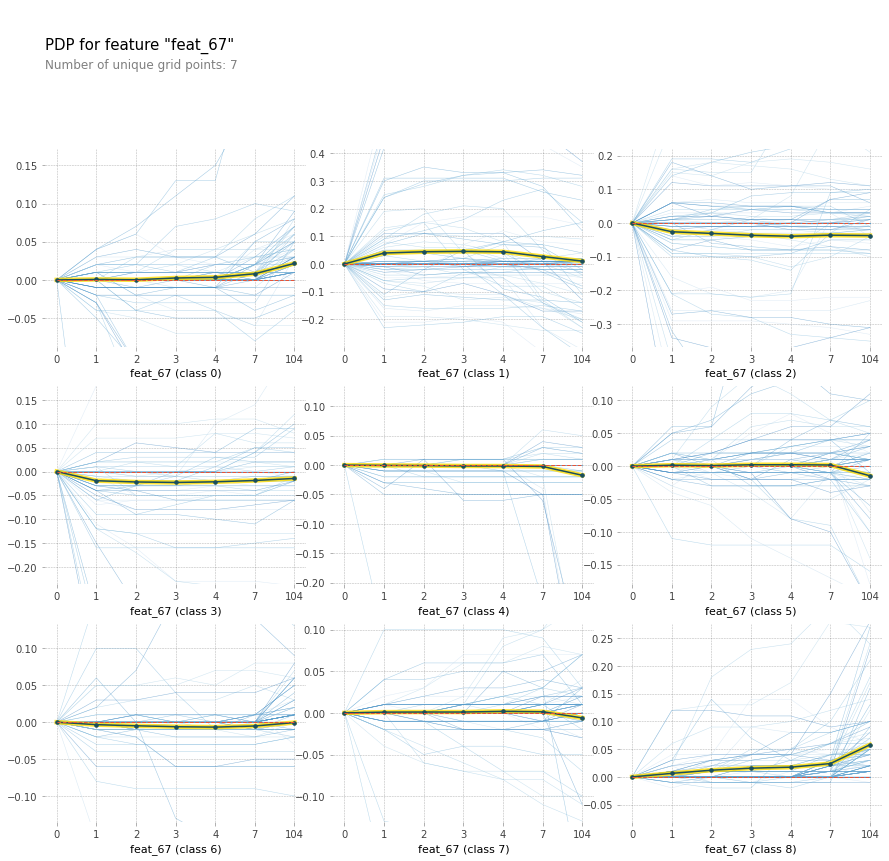

In [4]:
from pdpbox import pdp, get_dataset

test_otto = get_dataset.otto()
otto_data = test_otto['data']
otto_features = test_otto['features']
otto_model = test_otto['rf_model']
otto_target = test_otto['target']

pdp_feat_67_rf = pdp.pdp_isolate(model=otto_model,
                                 dataset=otto_data,
                                 model_features=otto_features,
                                 feature='feat_67')
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_feat_67_rf,
                         feature_name='feat_67',
                         center=True,
                         x_quantile=True,
                         ncols=3,
                         plot_lines=True,
                         frac_to_plot=100)

In [5]:
otto_model.shape

AttributeError: ignored

In [7]:
test_otto['target']

['target',
 'target_0',
 'target_1',
 'target_2',
 'target_3',
 'target_4',
 'target_5',
 'target_6',
 'target_7',
 'target_8']

In [ ]:
display(test_otto)

{'data':           id  feat_1  feat_2  feat_3  ...  target_5  target_6  target_7  target_8
 0          1       1       0       0  ...         0         0         0         0
 1          2       0       0       0  ...         0         0         0         0
 2          3       0       0       0  ...         0         0         0         0
 3          4       1       0       0  ...         0         0         0         0
 4          5       0       0       0  ...         0         0         0         0
 ...      ...     ...     ...     ...  ...       ...       ...       ...       ...
 61873  61874       1       0       0  ...         0         0         0         1
 61874  61875       4       0       0  ...         0         0         0         1
 61875  61876       0       0       0  ...         0         0         0         1
 61876  61877       1       0       0  ...         0         0         0         1
 61877  61878       0       0       0  ...         0         0         0       